### Fitting replication timing on S. cerevisiae ###

In [2]:
def plot_yeast(chr_number, pltshowQ=True):

    global fire_rates

    import numpy as np
    import math
    import os
    
    def fitfunction(timel, v0, st0, fit_step, maxiter, err_threshold,
                    cell_line='yeast', chr_number=''):
    
        v  = v0
        st = max(1, int(st0))
        x00 = np.array([(math.pi/(4*v))*i**(-2) for i in timel])
        lm  = 1000
    
        # choose safe slice for error
        n = len(timel)
        crop = slice(lm, -lm) if 2*lm < n else slice(None)
    
        def mse(a, b):
            return np.mean((a-b)**2)
    
        def fast_shift_add(dst, src, shift):
            if shift>0:      dst[shift:]+=src[:-shift]
            elif shift<0:    dst[:-(-shift)]+=src[-shift:]
    
        def fp(x, L, v):
            y = np.zeros_like(x)
            last_raw = np.zeros_like(x)
            last_exp = np.ones_like(x)
            unitary  = x.copy()
            for k in range(L+1):
                if k:
                    fast_shift_add(unitary, x,  k)
                    fast_shift_add(unitary, x, -k)
                exp2_raw = last_raw + unitary/v
                exp2     = np.exp(-exp2_raw)
                y       += (last_exp - exp2)/np.clip(unitary,1e-80,None)
                last_raw, last_exp = exp2_raw, exp2
            return y
    
        def fitf(time, lst, x0, j, fit_step):
            t, l = max(time[j],1e-80), max(lst[j],1e-80)
            return x0[j]*(l/t)**fit_step
    
        # ←── this is the only edited function ──→
        def cfit(time, lst, x0, fit_step):
            floor = 10**(-err_threshold)
            out   = np.empty_like(x0)
            for j in range(len(x0)):
                out[j] = max(fitf(time, lst, x0, j, fit_step), floor)
            return out
    
        L  = len(x00)//st
        ys = fp(x00, L, v)
        new_err0 = mse(timel[crop], ys[crop])
    
        os.makedirs("error", exist_ok=True)
        with open(f'error/mse_{cell_line}_chr[{chr_number}].txt','a') as mf:
            mf.write(f'{new_err0:.80f}\n')
            xs = x00.copy()
            for it in range(1, maxiter+1):
                xs = cfit(timel, ys, xs, fit_step)
                ys = fp(xs, L, v)
                err = mse(timel[crop], ys[crop])
                print(f'{it}/{maxiter} err={err:.4e}', end='\r')
                mf.write(f'{err:.80f}\n')
    
    
        # zero‐out any firing‐rate whose simulated timing deviates by >10 from observed
        threshold = 1
        mask = np.abs(ys - timel) > threshold
        #xs[mask] = 10**-15
    
        # recompute the simulated timing with those rates set to zero
        ys = fp(xs, L, v)
    
        return ['{:.30f}'.format(x) for x in xs], ys
    
    ### EXAMPLE USAGE ###
    cell_line   = "yeast"
    #chr_number  = 4
    fork_speed  = 1.4
    int_width   = 100
    fit_step    = 1.4
    iterations  = 100
    err_threshold = 15
    
    time_data = np.loadtxt(f"timing_data/time_data_{cell_line}_chr[{chr_number}].txt")
    int_widthf = lambda arr: max(1, int(len(arr)/int_width))
    
    fire_rates, time_sim = fitfunction(
        time_data,
        v0=fork_speed,
        st0=int_widthf(time_data),
        fit_step=fit_step,
        maxiter=iterations,
        err_threshold=err_threshold,
        cell_line=cell_line,
        chr_number=chr_number
    )
    
    import matplotlib.pyplot as plt
    scd = 0.8
    figsize = (scd*4, scd*3)
    lw_data, col_data = 2, 'gray'
    lw_sim,  col_sim  = 2, 'red'
    
    plt.figure(figsize=figsize)
    plt.plot(time_data, label="data", linewidth=lw_data, color=col_data, alpha=0.6)
    plt.plot(time_sim,  label="sim",  linewidth=lw_sim,  color=col_sim, alpha=0.6)
    plt.xlabel("")
    plt.gca().invert_yaxis()
    # plt.ylim(50, 10)  # optional
    plt.legend()
    plt.title(f"Chr {chr_number}")
    plt.tight_layout()
    #plt.savefig(f'figures/yeast_chr[{chr_number}].svg', bbox_inches='tight', transparent=True)
    if pltshowQ:
        plt.show()


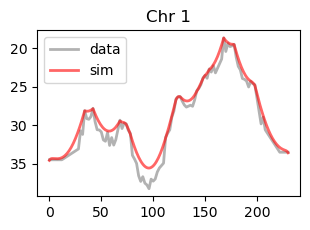

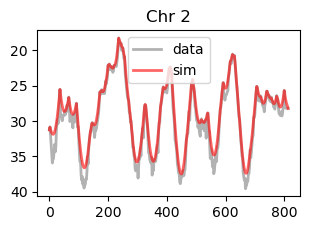

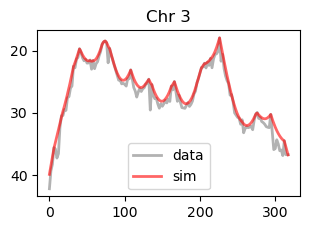

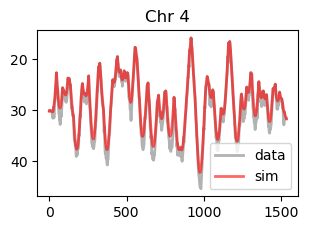

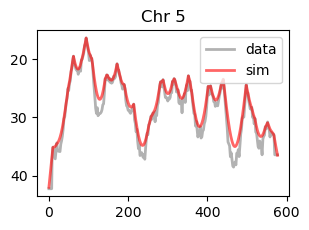

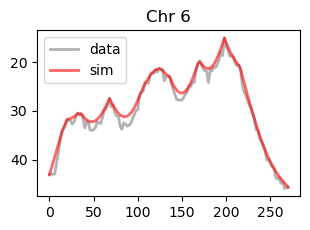

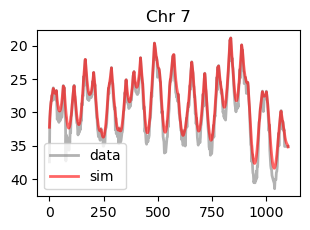

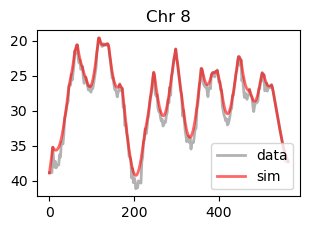

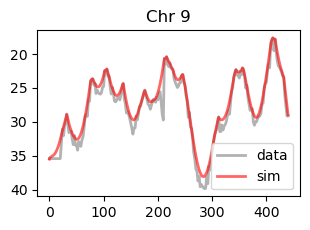

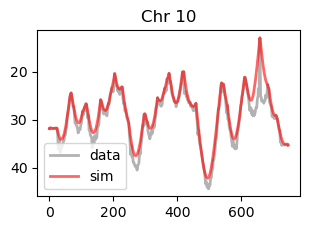

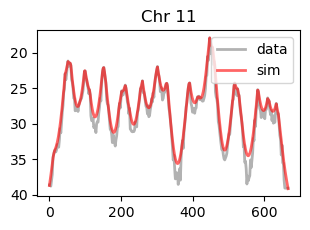

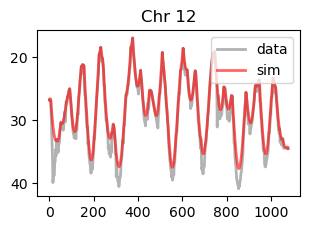

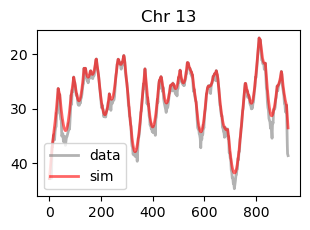

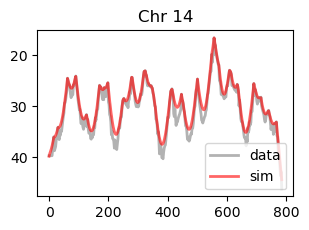

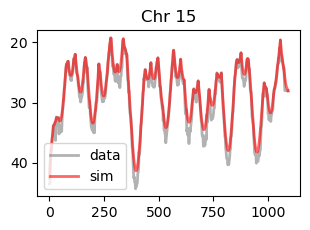

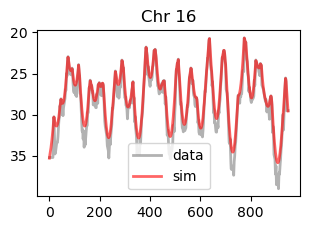

In [3]:
for chr in range(1,17):
    plot_yeast(chr)

In [4]:
def plot_fire(chr_number,
              csv_path='yeast_origins.csv',
              figsize=(9,1.5),
              ylim=(10**-4, 10**-1),
              line_color='C0',
              line_width=1.5,
              show_grid=False,
              grid_kwargs=None,
              span_color='orange',
              span_alpha=0.5,
              pltshowQ=True):

    global intervals
    
    import pandas as pd
    import matplotlib.pyplot as plt

    # load origins
    df = pd.read_csv(csv_path)
    df = df[df['Status (ARS)'].isin(['Confirmed','Likely'])]
    df = df[df['Chromosome'].astype(str)==str(chr_number)]
    origins = df[['Start','End']].div(1000).round(3).values.tolist()
    intervals = [range(int(s),int(e)+1) for s,e in origins]

    fire = [float(x) for x in fire_rates]

    plt.figure(figsize=figsize)
    for iv in intervals:
        plt.axvspan(iv[0], iv[-1], color=span_color, alpha=span_alpha)

    plt.plot(fire, color=line_color, linewidth=line_width)
    plt.yscale('log')
    if ylim: plt.ylim(ylim)
    plt.xlabel('')
    plt.ylabel('')
    if show_grid:
        plt.grid(**(grid_kwargs or {'which':'both','linestyle':'--','linewidth':0.5}))
    plt.tight_layout()
    #plt.savefig(f'figures/yeast_fire_chr[{chr_number}].svg', bbox_inches='tight', transparent=True)
    if pltshowQ:
        plt.show()

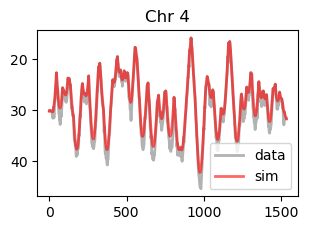

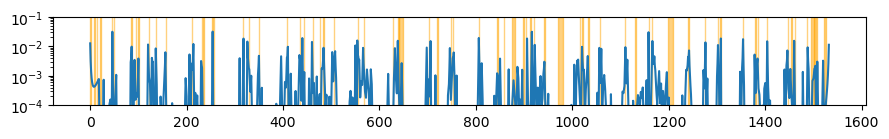

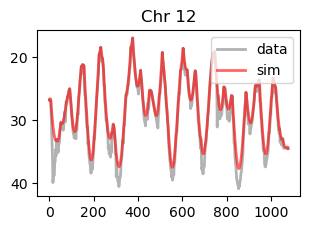

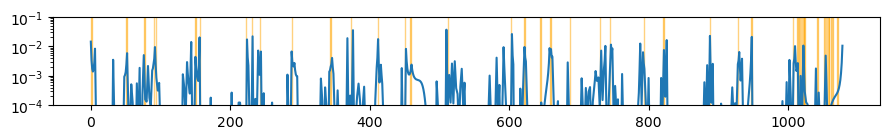

In [5]:
# Example
for chr_number in [4,12]:
    plot_yeast(chr_number)
    plot_fire(chr_number)